# Predictive Coding

In [1]:
import numpy as np
import nengo
from copy import deepcopy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

from training import *
from activations import *
from learning_rates import *
from equilibrium import *
from baseline import BaselineClassifier
from pc_network import *
from stimuli_data import *

# Classification Iris

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [3]:
x_data, y_data = load_iris(return_X_y=True)
y_data = y_data.reshape((y_data.shape[0],1))

In [4]:
enc = OneHotEncoder()
y_data = enc.fit_transform(y_data).toarray()

In [5]:
#define data
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=True)

In [6]:
with nengo.Network() as net:
    tau = 0.01
    #============== Run in Direct mode =======================
    net.config[nengo.Ensemble].neuron_type = nengo.Direct()
    #=========================================================
    net.config[nengo.Connection].synapse = tau
    net.config[nengo.Probe].synapse = 0
    
    epochs = 5
    learn_time = 0.2
    shuffle = True
    timeout = 10
    eps = 1e-2 #inference tolerance
    stab_time = 0.1
    inf_time = 0.2
    #define data
    x_input, y_input, learn_until = create_learning_inputs(x_train, y_train, epochs, stabilize_time=0, learn_time=learn_time, shuffle=shuffle)
    #add testing phase
    num_preds = add_inference_inputs(x_test, y_test, x_input, y_input, timeout=timeout, stab_time=stab_time, learn_until=learn_until)

    stim = nengo.Node(nengo.processes.Piecewise(x_input))   # sensory (bottom layer)
    pred = nengo.Node(nengo.processes.Piecewise(y_input))  # percept (top layer)
    
    #define learning rate
    tau_learn = ConstRate(0.1)
    #tau_learn = PowerRate(0.1, 10, 0.8, learn_until)
    
    # PC layers
    PC_net = PCNetwork(n_nodes=[4, 25, 3], tau_learn=LinearRate(0.1, 10, learn_until), symmetric=True, activation=Tanh, learn_until=learn_until)
    PC_net.connect_input(stim=stim)
    PC_net.connect_output(pred)

    # Set up a bunch of probes (so we can plot stuff later)
    p_stim = nengo.Probe(stim)
    #p_pc1v = nengo.Probe(PC_net.layers[0].v.output)
    #p_pc1e = nengo.Probe(PC_net.layers[0].e.output)
    #p_pc_end_v = nengo.Probe(PC_net.layers[-1].v.output)
    #p_pc_end_e = nengo.Probe(PC_net.layers[-1].e.output)
    p_pred = nengo.Probe(pred)

    val_probes, err_probes = PC_net.get_probes()

dt = 0.0001
sim = nengo.Simulator(net, dt=dt)

Build finished in 0:00:01.                                                      


In [7]:
train_network(sim, learn_until)

Simulation finished in 0:07:23.                                                 


In [8]:
conv_metric = "Max"

if conv_metric == "L2":
    preds, eq_times = test_network_L2(sim, PC_net, num_preds, timeout, inf_time, stab_time, val_probes[-1], eps)
elif conv_metric == "L1":
    preds, eq_times = test_network_L1(sim, PC_net, num_preds, timeout, inf_time, stab_time, val_probes[-1], eps)
elif conv_metric == "Max":
    preds, eq_times = test_network_max(sim, PC_net, num_preds, timeout, inf_time, stab_time, val_probes[-1], eps)

Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:

In [9]:
print(preds)

[[ 0.77063983  0.75909672 -0.25507255]
 [ 1.14179605  0.94472747 -0.35710969]
 [ 1.00108096  0.27874112 -0.12794856]
 [ 0.19174441 -0.19222922  0.58811643]
 [        inf         inf         inf]
 [        inf         inf         inf]
 [ 0.80784662  0.12354121 -0.09347717]
 [        inf         inf         inf]
 [        inf         inf         inf]
 [ 0.18260691  0.12284986  0.40443787]
 [ 0.02947888 -0.06771114  0.84312185]
 [ 0.19876934 -0.24437441  0.57971516]
 [        inf         inf         inf]
 [ 0.77065327 -0.12481757  0.09302687]
 [ 0.93255688  0.33881644 -0.14361679]
 [        inf         inf         inf]
 [        inf         inf         inf]
 [ 0.12286962  0.35754401  0.38110972]
 [        inf         inf         inf]
 [        inf         inf         inf]
 [        inf         inf         inf]
 [        inf         inf         inf]
 [        inf         inf         inf]
 [        inf         inf         inf]
 [        inf         inf         inf]
 [        inf         inf

Architecture:
- Layers: [4, 25, 3]
- Activations: ["<class 'activations.Tanh'>", "<class 'activations.Tanh'>"]
- Symmetric: True
- Learning rate: ['Linear (start=0.1, stop=10, slope=0.0824999999999992)', 'Linear (start=0.1, stop=10, slope=0.0824999999999992)']
Trained the network for 5 epochs (shuffled=True), holding each sample for 0.2 s.
Timeout: 10, inference time: 0.2, stabilize time: 0.1
Tolerance: 0.01 with Max norm as convergence metric.
Testing:
The number of each class in the test set: [13.  9.  8.]
There were 17 divergences during inference.
Test accuracy: 0.3
We learn until t=120.00000000000117


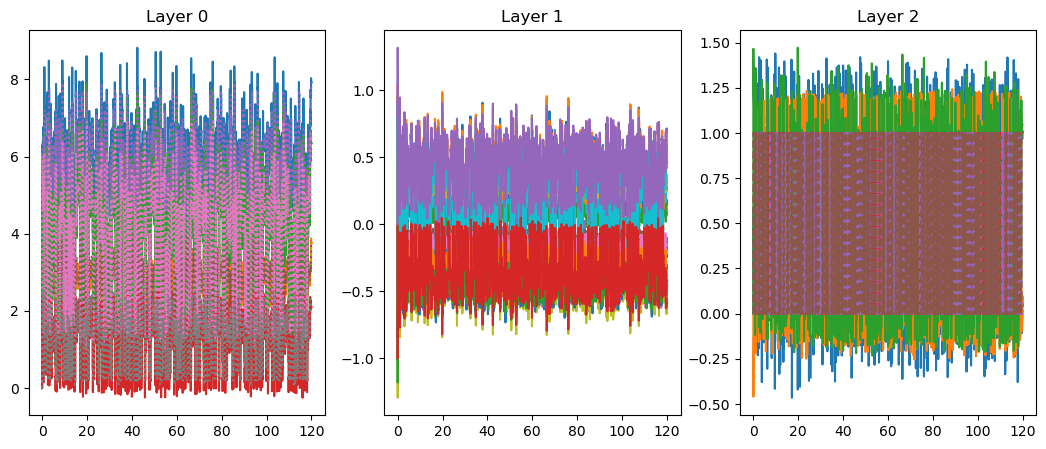

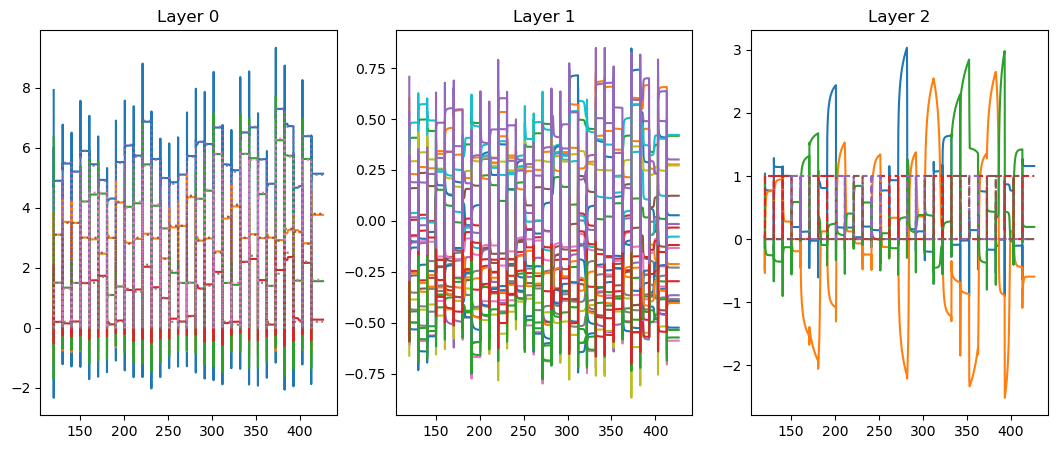

In [10]:
"""
pred_class = np.zeros_like(preds)
indices = np.argmax(preds, axis=1)
i = 0
for idx in indices:
    pred_class[i,idx] = 1
    i += 1

acc = np.sum(pred_class*y_test)/y_test.shape[0]
"""
acc = 0
num_infs = 0 #the number of divergences during inference
for i in range(preds.shape[0]):
    if not np.any(np.isinf(preds[i])):
        if np.argmax(preds[i]) == np.argmax(y_test[i]):
            acc += 1
    else:
        num_infs += 1

acc /= y_test.shape[0]

### Print summary of the network learning ###
print("Architecture:")
print(f"- Layers: {[layer.n_nodes for layer in PC_net.layers]}")
print(f"- Activations: {[str(act) for act in PC_net.activation]}")
print(f"- Symmetric: {PC_net.symmetric}")
print(f"- Learning rate: {[str(l) for l in PC_net.tau_learn]}")
print(f"Trained the network for {epochs} epochs (shuffled={shuffle}), holding each sample for {learn_time} s.")
print(f"Timeout: {timeout}, inference time: {inf_time}, stabilize time: {stab_time}")
print(f"Tolerance: {eps} with {conv_metric} norm as convergence metric.")

print("Testing:")
print(f"The number of each class in the test set: {np.sum(y_test, axis=0)}")
print(f"There were {num_infs} divergences during inference.")
#print(f"The number of each class predicted when testing: {np.sum(pred_class, axis=0)}")

print(f"Test accuracy: {acc}")

### Plotting ###

n_layers = len(PC_net.layers)

fig, ax = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 4000]
idx = [7000, 10000]
#idx = [18000, 20000]
idx = [0, len(sim.trange())]
idx = [0, int(learn_until/dt)]
tt = sim.trange()[idx[0]:idx[1]]

for k in range(n_layers):
    ax[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax[k].set_title(f'Layer {k}');

ax[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':', label="Stim");  
ax[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--', label="Pred");


print(f"We learn until t={learn_until}")

n_layers = len(PC_net.layers)

fig2, ax2 = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 2000]
idx = [7000, 7800]
idx = [int(learn_until/dt), -1] #plot only learning segments
#idx = [0, len(sim.trange())]
tt = sim.trange()[idx[0]:idx[1]]

for k in range(n_layers):
    ax2[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax2[k].set_title(f'Layer {k}');


ax2[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':');
ax2[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--');

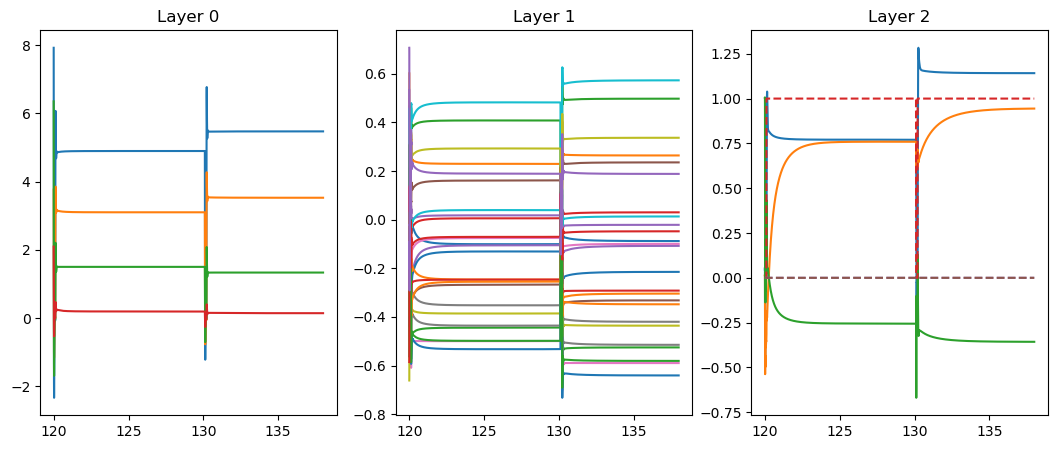

In [16]:
n_layers = len(PC_net.layers)

fig2, ax2 = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 2000]
idx = [7000, 7800]
idx = [int(learn_until/dt), -1] #plot only learning segments
idx = [1200000, 1380000]
tt = sim.trange()[idx[0]:idx[1]]

for k in range(n_layers):
    ax2[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax2[k].set_title(f'Layer {k}');


#ax2[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':');
ax2[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--');

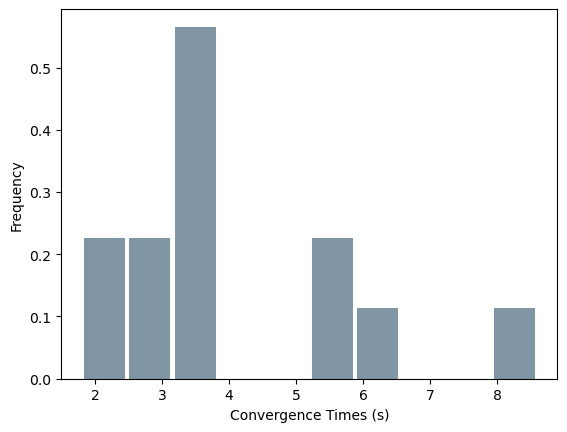

In [12]:
t_plot = []
for time in eq_times:
    if not np.isinf(time):
        t_plot.append(time)
t_plot = np.array(t_plot)

plt.figure()
plt.hist(t_plot, bins=10, density=True, rwidth=0.9, alpha=0.8, color='#607c8e')

plt.xlabel("Convergence Times (s)")
plt.ylabel("Frequency")
plt.show()

In [13]:
#what is the baseline test accuracy of classifiers?

base = BaselineClassifier()
base.fit(x_train, y_train)

random_acc, uniform_acc, zero_acc = base.empirical_accuracy(x_test, y_test, N=10000)

print(f"Random accuracy = {random_acc}")
print(f"Uniform accuracy = {uniform_acc}")
print(f"Zero rate accuracy = {zero_acc}")

Random accuracy = 0.32918666666668983
Uniform accuracy = 0.3351000000000245
Zero rate accuracy = 0.2666666666667063


# Classification Eye Inhibition

In [ ]:
x_data1 = transform_eye_inhibition(load_eye_inhibition())
x_data2 = shuffle_data(x_data1)

#train and test on same data
x_train = np.vstack((x_data1, x_data2))
x_test = np.vstack((x_data1, x_data2))

y_train = np.concatenate((np.ones(x_data1.shape[0]), np.zeros(x_data2.shape[0])))
y_test = np.concatenate((np.ones(x_data1.shape[0]), np.zeros(x_data2.shape[0])))

In [ ]:
with nengo.Network() as net:
    tau = 0.01
    #============== Run in Direct mode =======================
    net.config[nengo.Ensemble].neuron_type = nengo.Direct()
    #=========================================================
    net.config[nengo.Connection].synapse = tau
    net.config[nengo.Probe].synapse = 0
    
    epochs = 4
    learn_time = 0.2
    shuffle = True
    stab_time = 0.05
    inf_time = 0.2
    #define data
    x_input, y_input, learn_until = create_learning_inputs(x_train, y_train, epochs, stabilize_time=0, learn_time=learn_time, shuffle=shuffle)
    #add testing phase
    num_preds = add_inference_inputs(x_test, y_test, x_input, y_input, inf_time=inf_time, stab_time=stab_time, learn_until=learn_until)

    stim = nengo.Node(nengo.processes.Piecewise(x_input))   # sensory (bottom layer)
    pred = nengo.Node(nengo.processes.Piecewise(y_input))  # percept (top layer)
    
    #define learning rate
    tau_learn = ConstRate(0.1)
    #tau_learn = PowerRate(0.1, 10, 0.8, learn_until)
    
    # PC layers
    PC_net = PCNetwork(n_nodes=[6800, 3400, 1], tau_learn=tau_learn, symmetric=True, activation=Tanh(), learn_until=learn_until)
    PC_net.connect_input(stim=stim)
    PC_net.connect_output(pred)

    # Set up a bunch of probes (so we can plot stuff later)
    #p_stim = nengo.Probe(stim)
    #p_pc1v = nengo.Probe(PC_net.layers[0].v.output)
    #p_pc1e = nengo.Probe(PC_net.layers[0].e.output)
    p_pc_end_v = nengo.Probe(PC_net.layers[-1].v.output)
    p_pc_end_e = nengo.Probe(PC_net.layers[-1].e.output)
    p_pred = nengo.Probe(pred)

    #val_probes, err_probes = PC_net.get_probes()

dt = 0.0001
sim = nengo.Simulator(net, dt=dt)

In [ ]:
train_network(sim, learn_until)

In [ ]:
preds = test_network(sim, PC_net, num_preds, inf_time, stab_time, p_pc_end_v)

In [ ]:
### Plotting ###

n_layers = len(PC_net.layers)

fig, ax = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 4000]
idx = [4000, 16000]
#idx = [18000, 20000]
idx = [0, int(learn_until/dt)]
#idx = [115000, 120000]
tt = sim.trange()[idx[0]:idx[1]]

#for k in range(n_layers):
#    ax[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax[k].set_title(f'Layer {k}');
ax[-1].plot(tt, sim.data[p_pc_end_v][idx[0]:idx[1]]); ax[-1].set_title(f'Last Layer');

#ax[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':', label="Stim");  
ax[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--', label="Pred");


print(f"We learn until t={learn_until}")

n_layers = len(PC_net.layers)

fig2, ax2 = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 2000]
idx = [1200000, 1216000]
idx = [int(learn_until/dt), -1] #plot only learning segments
#idx = [0, len(sim.trange())]
tt = sim.trange()[idx[0]:idx[1]]

#for k in range(n_layers):
#    ax2[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax2[k].set_title(f'Layer {k}');
ax2[-1].plot(tt, sim.data[p_pc_end_v][idx[0]:idx[1]]); ax2[-1].set_title(f'Last Layer');

#ax2[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':');    
ax2[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--');

In [ ]:
pred_class = np.zeros_like(preds)
indices = np.argmax(preds, axis=1)
i = 0
for idx in indices:
    pred_class[i,idx] = 1
    i += 1

acc = np.sum(pred_class*y_test)/y_test.shape[0]

### Print summary of the network learning ###
print("Architecture:")
print(f"- Layers: {[layer.n_nodes for layer in PC_net.layers]}")
print(f"- Activations: {[str(entry) for entry in PC_net.activation]}")
print(f"- Symmetric: {PC_net.symmetric}")
print(f"- Learning rate: {[str(entry) for entry in PC_net.tau_learn]}")
print(f"Trained the network for {epochs} epochs (shuffled={shuffle}), holding each sample for {learn_time} s. Inference time was {inf_time} s.")

print("Testing:")
print(f"The number of each class in the test set: {np.sum(y_test, axis=0)}")
print(f"The number of each class predicted when testing: {np.sum(pred_class, axis=0)}")

print(f"Test accuracy: {acc}")

### Plotting ###

n_layers = len(PC_net.layers)

fig, ax = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 4000]
idx = [4000, 16000]
#idx = [18000, 20000]
idx = [0, int(learn_until/dt)]
#idx = [115000, 120000]
tt = sim.trange()[idx[0]:idx[1]]

for k in range(n_layers):
    ax[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax[k].set_title(f'Layer {k}');

ax[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':', label="Stim");  
ax[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--', label="Pred");


print(f"We learn until t={learn_until}")

n_layers = len(PC_net.layers)

fig2, ax2 = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 2000]
idx = [1200000, 1216000]
idx = [int(learn_until/dt), -1] #plot only learning segments
#idx = [0, len(sim.trange())]
tt = sim.trange()[idx[0]:idx[1]]

for k in range(n_layers):
    ax2[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax2[k].set_title(f'Layer {k}');


ax2[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':');    
ax2[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--');

In [ ]:
#what is the baseline test accuracy of classifiers?

base = BaselineClassifier()
base.fit(x_train, y_train)

random_acc, uniform_acc, zero_acc = base.empirical_accuracy(x_test, y_test, N=1000)

print(f"Random accuracy = {random_acc}")
print(f"Uniform accuracy = {uniform_acc}")
print(f"Zero rate accuracy = {zero_acc}")

# Classification Iris, Equilibrium Functions

In [ ]:
timeout = 4
eps = 1e-5

In [ ]:
preds, eq_times = test_network_L2(sim, PC_net, num_preds, inf_time, stab_time, val_probes[-1], eps=1e-5, timeout=timeout)

In [ ]:
pred_class = np.zeros_like(preds)
indices = np.argmax(preds, axis=1)
i = 0
for idx in indices:
    pred_class[i,idx] = 1
    i += 1

acc = np.sum(pred_class*y_test)/y_test.shape[0]

### Print summary of the network learning ###
print("Architecture:")
print(f"- Layers: {[layer.n_nodes for layer in PC_net.layers]}")
print(f"- Activations: {[str(act) for act in PC_net.activation]}")
print(f"- Symmetric: {PC_net.symmetric}")
print(f"- Learning rate: {[str(l) for l in PC_net.tau_learn]}")
print(f"Trained the network for {epochs} epochs (shuffled={shuffle}), holding each sample for {learn_time} s. Inference time was {inf_time} s." + 
      f"Stabilizing time was {stab_time} s")

print("Testing:")
print(f"The number of each class in the test set: {np.sum(y_test, axis=0)}")
print(f"The number of each class predicted when testing: {np.sum(pred_class, axis=0)}")

print(f"Test accuracy: {acc}")

### Plotting ###

n_layers = len(PC_net.layers)

fig, ax = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 4000]
idx = [7000, 10000]
#idx = [18000, 20000]
idx = [0, len(sim.trange())]
idx = [0, int(learn_until/dt)]
tt = sim.trange()[idx[0]:idx[1]]

for k in range(n_layers):
    ax[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax[k].set_title(f'Layer {k}');

ax[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':', label="Stim");  
ax[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--', label="Pred");


print(f"We learn until t={learn_until}")

n_layers = len(PC_net.layers)

fig2, ax2 = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 2000]
idx = [7000, 7800]
idx = [int(learn_until/dt), -1] #plot only learning segments
#idx = [0, len(sim.trange())]
tt = sim.trange()[idx[0]:idx[1]]

for k in range(n_layers):
    ax2[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax2[k].set_title(f'Layer {k}');


ax2[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':');
ax2[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--');

In [ ]:
n_layers = len(PC_net.layers)

fig2, ax2 = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 2000]
idx = [7000, 7800]
idx = [int(learn_until/dt), -1] #plot only learning segments
idx = [int(learn_until/dt), int(learn_until/dt) + ]
tt = sim.trange()[idx[0]:idx[1]]

for k in range(n_layers):
    ax2[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax2[k].set_title(f'Layer {k}');


ax2[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':');
ax2[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--');

In [ ]:
#what is the baseline test accuracy of classifiers?

base = BaselineClassifier()
base.fit(x_train, y_train)

random_acc, uniform_acc, zero_acc = base.empirical_accuracy(x_test, y_test, N=10000)

print(f"Random accuracy = {random_acc}")
print(f"Uniform accuracy = {uniform_acc}")
print(f"Zero rate accuracy = {zero_acc}")